In [1]:
!pip install --quiet -U langchain langchainhub langchain_community langchain-tools openai langgraph langchain_groq python-dotenv langchain_experimental duckduckgo-search groq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.2 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
groq_api = userdata.get('groq_api')
langsmith_api = userdata.get('LangSmith')

In [3]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = langsmith_api
os.environ["LANGCHAIN_PROJECT"] = "LiveLangGraph"

In [4]:
from groq import Groq
client = Groq(api_key=groq_api)

In [ ]:
chat_completion = client.chat.completions.create(
    messages=[
        {"role": "user", "content": "Explain the importance of fast language models"}
    ],
    model="mixtral-8x7b-32768",
    temperature=0.1
)

print(chat_completion.choices[0].message.content)

Fast language models are important for several reasons:

1. Real-time applications: Fast language models are essential for real-time applications such as speech recognition, machine translation, and text summarization. These applications require quick and accurate responses, and slow language models can result in delayed or incorrect outputs, which can be frustrating for users.
2. Large-scale applications: Fast language models are necessary for large-scale applications such as social media monitoring, customer service chatbots, and content recommendation systems. These applications require processing large volumes of data in real-time, and slow language models can result in significant delays and reduced efficiency.
3. User experience: Fast language models can significantly improve the user experience by providing quick and accurate responses. Users expect instant gratification, and slow language models can lead to user frustration and abandonment.
4. Cost-effective: Fast language mode

FINAL

In [5]:
PREFIX = """[INST]Respond to the human as helpfully and accurately as possible. You have access to the following tools:"""

FORMAT_INSTRUCTIONS = """Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).

Valid "action" values: "Final Answer" or {tool_names}
while passing query to the tool make sure not to pass multiple queries.
Provide only ONE action per $JSON_BLOB, as shown:

```
{{{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}}}
```

Follow this format:

Question: input question to answer
Thought: consider previous and subsequent steps
Action:
```
$JSON_BLOB
```
Observation: action result
... (repeat Thought/Action/Observation N times)
Thought: I know what to respond
Action:
```
{{{{
  "action": "Final Answer",
  "action_input": "Final response to human"
}}}}
```[/INST]"""

SUFFIX = """Begin! Reminder to ALWAYS respond with a valid json blob of a single action. Use tools if necessary. Respond directly if appropriate. Format is Action:```$JSON_BLOB```then Observation:.
Thought:[INST]"""

HUMAN_MESSAGE_TEMPLATE = "{input}\n\n{agent_scratchpad}"

In [6]:
from langchain.agents import StructuredChatAgent, AgentExecutor
from langchain.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import create_react_agent,ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain.agents import Tool
import pandas as pd
from langchain_experimental.agents import create_pandas_dataframe_agent

def create_agent(csv_path):
  memory = MemorySaver()
  search = DuckDuckGoSearchRun(max_results=3)
  # python_repl_tool = PythonREPLTool()


  llm = ChatGroq(api_key=groq_api, model="llama-3.2-90b-text-preview")
  pd_agent = create_pandas_dataframe_agent(llm,
                                          pd.read_csv(csv_path),
                                          verbose=True,
                                          allow_dangerous_code=True,
                                          )
  # pd_agent.run("generate a graph with insights from the dataset, also explain the findings from the plot")
  tools = [
      Tool(
          name = "Search",
          func=search.run,
          description="""
  Useful for when you need to find information related to Exploratory Data Analysis(EDA) on web.
  Input should be a search query.
  """
      ),
      Tool(
          name = "CSV_Agent",
          func=pd_agent.run,
          description="""
  Useful when you need to carry out EDA with insights from the dataset provided from.
  Input should be a search query.
  """
      ),
  ]

  agent = StructuredChatAgent.from_llm_and_tools(
      llm,
      tools,
      prefix=PREFIX,
      suffix=SUFFIX,
      human_message_template=HUMAN_MESSAGE_TEMPLATE,
      format_instructions=FORMAT_INSTRUCTIONS,
  )
  agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, checkpointer=memory, handle_parsing_errors=True)
  return agent_executor

In [7]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# State
class State(TypedDict):
    messages: List

# Initializing langGraph
graph_builder = StateGraph(State)

def chatbot(state: State):
    agent_executor = create_agent(csv_path=csv_path)
    return {"messages": [agent_executor.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

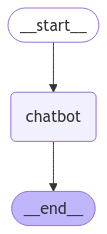

In [8]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Enter csv path : /content/sample_data/california_housing_train.csv
User: hi what is the concept of EDA?


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Search",
  "action_input": "Concept of Exploratory Data Analysis"
}
```
Observation: Exploratory Data Analysis (EDA) is a crucial initial step in data science projects. It involves analyzing and visualizing data to understand its key characteristics, uncover patterns, and identify relationships between variables refers to the method of studying and exploring record sets to apprehend their predominant traits, discover patterns ... Exploratory Data Analysis (EDA) is an analytical approach aimed at uncovering the inherent characteristics of datasets, utilizing statistical and visualization techniques. Exploratory data analysis is the primary step in many data analysis processes. It helps analysts visualize patterns, characteristics, and relationships between variables. Here's a quick overview of the steps needed to condu

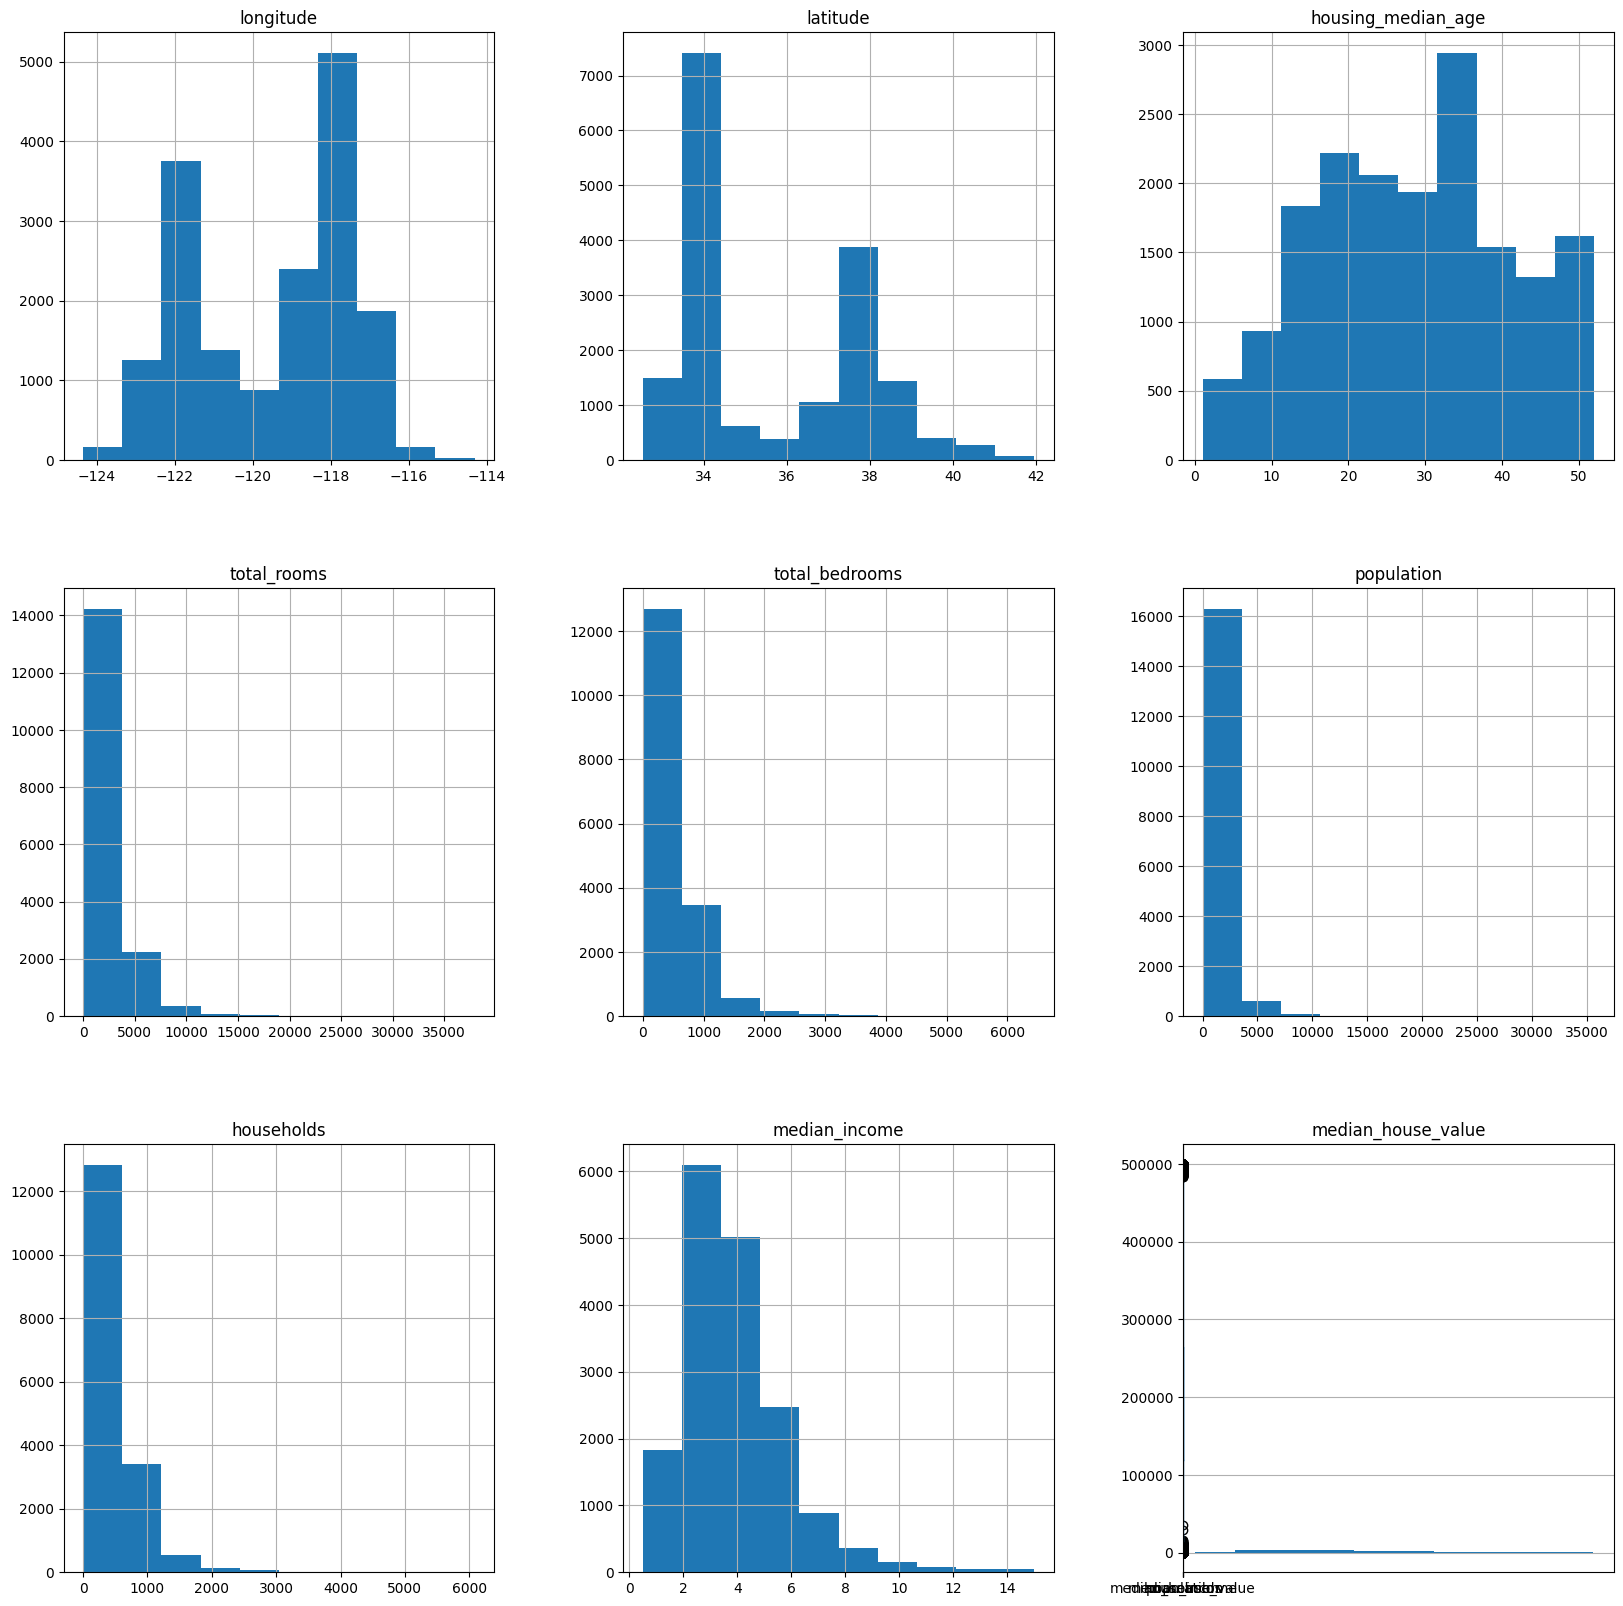

In [9]:
csv_path = input("Enter csv path : ")
while True:
  if csv_path:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    # Print to inspect the message structure
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Message structure:", value["messages"][-1])
            print("Assistant:", value["messages"][-1].get("output"))